# RoBERTa Classifier with target LM pretraining

In this notebook we will train a RoBERTa classifier for the proxy task using the pretrained target language model for initialization.  The language model is trained in 04_roberta_lm.ipynb.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.text import *
from transformers import RobertaForSequenceClassification, RobertaConfig
import eval_models
from train_utils import *

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.59
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(1)

### Prep databunch

In [5]:
bs = 64
seed = 42
tok_model_dir = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/tokenizer_target'
max_seq_len = 256

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')

In [8]:
bpe_path = Path('/home/tjtsai/.fastai/data/bscore_lm/bpe_data')
train_df = pd.read_csv(bpe_path/'train64.char.csv')
valid_df = pd.read_csv(bpe_path/'valid64.char.csv')
test_df = pd.read_csv(bpe_path/'test64.char.csv')

In [9]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Train Classifier

In [10]:
model_class, config_class = RobertaForSequenceClassification, RobertaConfig
model_path = '/home/tjtsai/.fastai/data/bscore_lm/bpe_data/models/roberta_train-target_lm'

In [11]:
config = config_class.from_pretrained(model_path)
config.num_labels = data_clas.c

In [12]:
transformer_model = model_class.from_pretrained(model_path, config = config)
custom_transformer_model = RobertaModelWrapper(transformer_model, pad_idx)

In [32]:
# learner.destroy()
# torch.cuda.empty_cache()

this Learner object self-destroyed - it still exists, but no longer usable


In [13]:
learner = Learner(data_clas, custom_transformer_model, metrics=[accuracy, FBeta(average='macro', beta=1)])

In [15]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]

In [17]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, o

In [18]:
seed_all(seed)

In [19]:
learner.freeze_to(-1)

In [21]:
#learner.summary()

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 3.02E-04


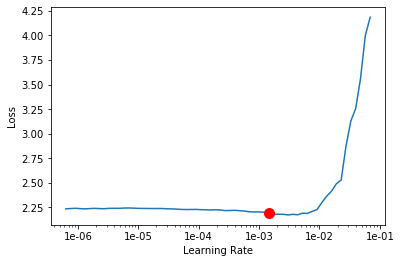

In [23]:
learner.recorder.plot(suggestion=True)

In [24]:
lr = 3e-4

In [25]:
learner.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.640435,1.610262,0.409259,0.376419,00:51
1,1.577474,1.599348,0.414352,0.395264,00:52


In [26]:
learner.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.625678,1.615166,0.399630,0.379556,00:51
1,1.535350,1.588950,0.413981,0.394732,00:52


In [27]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.268918,1.542570,0.458796,0.445470,01:00
1,0.976911,1.525741,0.475370,0.463372,01:01


In [28]:
learner.freeze_to(-3)
learner.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.894145,1.596980,0.480648,0.469073,01:12
1,0.648468,1.640450,0.487500,0.478129,01:14


In [14]:
learner.save('roberta_train-target_clas')
#learner.load('roberta_train-target_clas')

Learner(data=TextClasDataBunch;

Train: LabelList (32400 items)
x: TextList
<s> 一一一一一丂一一</w> 一一乀一一丈一一</w> 一一一一一丈一一</w> 一一丐一一丈丄一</w> 一一一一一一丁一</w> 一一亀一一一一一</w> 一一一一丈一一一</w> 一一一一丠一一一</w> 一一一一一丁一一</w> 一一丠一一丄一一</w> 一一一一一丄一一</w> 一一丈一一丈一一</w> 一一一一一丁一一</w> 一一丐一一丁一一</w> 一一一一亀一一一</w> 一一丂一一丂一一</w> 一一丁一丐一一一</w> 一亀一一丠一一一</w> 一乀一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一一一一丠一一一</w> 一一一一一丁一一</w> 一一一一一丄一一</w> 一一丄一一丐一一</w> 一一一一一丐一一</w> 一一丁一一丐一一</w> 一一一一一乀一一</w> 一一丂一亀一一一</w> 一一一一丐一一一</w> 一一一一亀一一一</w> 一一一丁一丈一一</w> 一一一一一丈一一</w> 一一乀一一一一一</w> 一一一一一一丁一</w> 一一一一一丅一一</w> 一一一一乀一一一</w> 一一亀一一一一一</w> 一一一一一丄一一</w> 一一一一一丐一一</w> 一一一一一亀一一</w> 一一丄一一一一一</w> 一一一一一丁一一</w> 一一一一一丄一一</w> 一一一一一丐一一</w> 一一丐一一一一一</w> 一一一一一丈一一</w> 一一一一一丂一一</w> 一一一一亀一一一</w> 一一一一丨丁一一</w> 一一丁一一一一一</w> 一一丄一一一一一</w> 一一丐一一一一一</w> 一一亀一一一一一</w> 一一亀一一一一一</w> 一一亀一一一一一</w> 一丠一一一一一一</w> 一亀一一一一一一</w> 一一丂一一一一一</w> 一一丐一一一一一</w> 一一丐一一一一一</w> 一一丐一一丁一一</w> 一一一一亀一一一</w> </s>,<s> 一一丄一亀丂一一</w> 一一丈一一一一一</w> 一一丄一一一一一</w> 乀一一一一一一一</w> 一乀一一一一一一</w> 一一丄一一丅一一</w> 一

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [15]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [16]:
learner.validate(data_clas_test.valid_dl)

[1.6298105, tensor(0.4948), tensor(0.4867)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [17]:
train_fullpage_df = pd.read_csv(bpe_path/'train.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test.fullpage.char.csv')

In [18]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [19]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.558282196521759, 0.6104294657707214),
 (0.5281093124744477, 0.561445166785824))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [20]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

In [21]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [22]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.6188650131225586, 0.6196318864822388),
 (0.5801504413711589, 0.5554063833775533))

### Error Analysis

In [23]:
interp = ClassificationInterpretation.from_learner(learner)

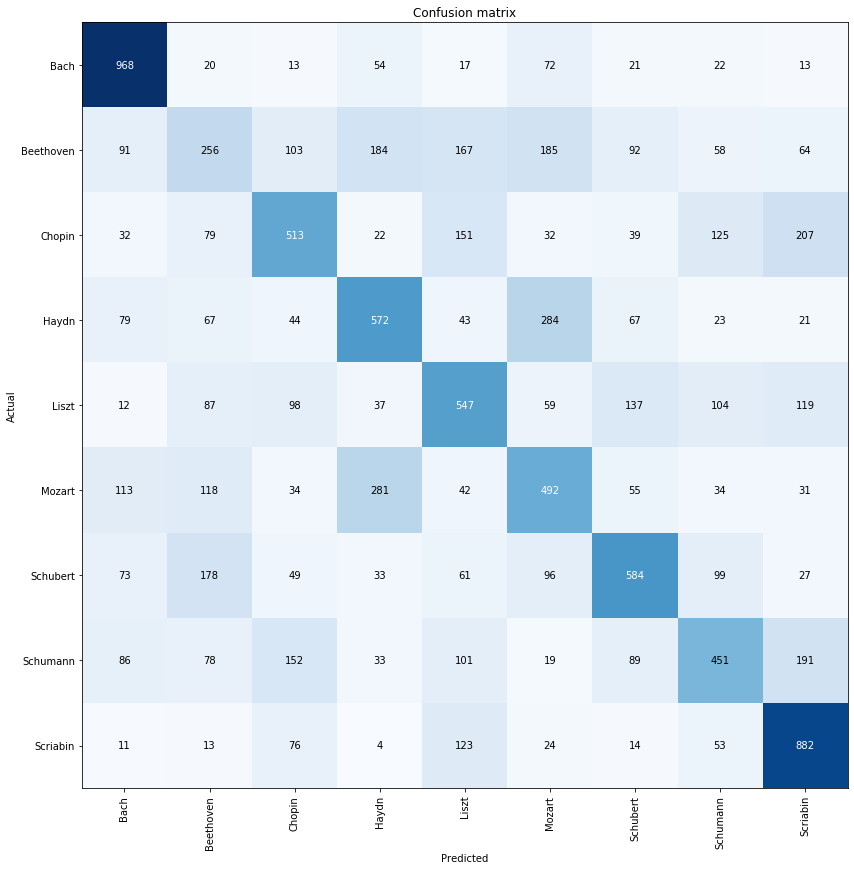

In [24]:
interp.plot_confusion_matrix(figsize=(12,12))